#**<font color='yellow'>Model Name: EfficientNetB3</font>**
##**Date: 21<sup>st</sup>January 2020**

### **Mount Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####**Import Necessary Library**

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd

import glob as gb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D ,LeakyReLU

####**Define directories path**

In [ ]:
## Define the directories for training, testing, and validation
train_directory = '/content/drive/MyDrive/ISIC2018/train'
test_directory = '/content/drive/MyDrive/ISIC2018/test'
valid_directory = '/content/drive/MyDrive/ISIC2018/validation'

####**Create dataset function using keras/Tensorflow**

In [ ]:
IMG_SIZE = (299, 299)  # define resolution (299,299) /(224,224)
BATCH_SIZE = 128       # varies from dataset to datset prefferable 128/68/32

In [ ]:
# Create TensorFlow datasets for training, testing, and validation
#you can customize parameters as per dataset
train_dataset = image_dataset_from_directory(
    train_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

test_dataset = image_dataset_from_directory(
    test_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

valid_dataset = image_dataset_from_directory(
    valid_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

Found 5200 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


In [ ]:
# Optional: You can also specify the class names if you have a specific order for your classes
class_names = train_dataset.class_names

# Print class names
print("Class Names:", class_names)

Class Names: ['benign', 'malignant']


<ipython-input-9-692dc6d515a1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[ "0","1"], y=Dataset, palette="rocket")  ## change the class name
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


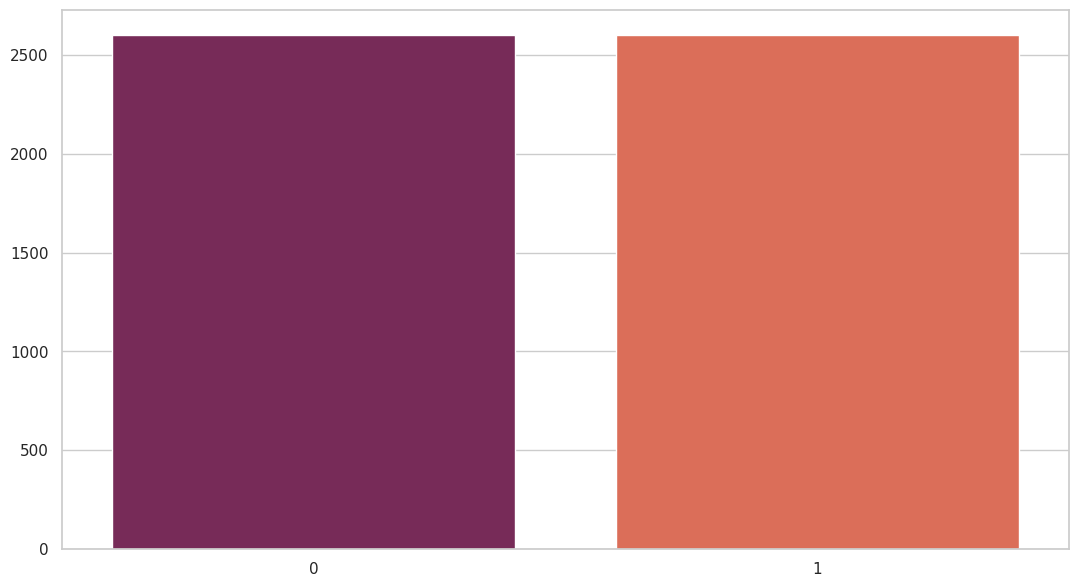

In [ ]:
#plot bar chart for demonstrating data size
sns.set_theme(style="whitegrid")
Dataset = []
for folder in os.listdir(train_directory):
    files = gb.glob(pathname=str(train_directory + "/" + folder +"/*.*"))
    Dataset.append(len(files))
plt.figure(figsize=(13,7))                    ## change the len size
sns.barplot(x=["0","1"], y=Dataset, palette="rocket")  ## change the class name
plt.show()

## <font color='blue'>Build the Model</font>

In [ ]:
base_learning_rate = 0.001 # prefferable lr is 0.0001 or 0.001
IMG_SHAPE = IMG_SIZE +(3,)

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
type(base_model)
## N.B: changle the model name

preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [ ]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)

Numbers of Layers = 238
top_bn
top_activation


In [ ]:
# iterate over first batch (32 image) in trainset
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 10, 10, 1280)


In [ ]:
def create_model( image_shape=IMG_SHAPE):
    ''' Define a tf.keras model for multi-class classification out of the *model name* (Resnet/Inception...) '''
    ##change the *model name*
    #downloaded_model = tf.keras.applications.EfficientNetB3(input_shape=IMG_SHAPE, include_top= False, weights='imagenet')
    # Load the EfficientNetB0 model
    downloaded_model = tf.keras.applications.EfficientNetB0(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    downloaded_model.trainable = True
    for layer in downloaded_model.layers[0 : 291]:
        layer.trainable = False

    inputs = tf.keras.Input(image_shape)
    x = preprocess_input(inputs)
    x = downloaded_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    prediction_layer = tf.keras.layers.Dense(7 ,activation = "softmax")   ## change the first parameter according to the class len
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

In [ ]:
## specify function name as model name
model = create_model(IMG_SHAPE)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 10, 10, 1280)      4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 7)                 8967      
                                                                 
Total params: 4058538 (15.48 MB)
Trainable params: 8967 (35

In [ ]:
## customize optimizer as Nadam or Adam
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
## set the path name as *dataset/Lr/optimizer_name/model_name*
model_filepath="/content/drive/MyDrive/0.001/Nadam/EfficientNetB3/efficientnet-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath = model_filepath ,
    monitor ='val_accuracy',
    mode = 'max' ,
    save_best_only =True ,
    verbose = 1
)

In [ ]:
#avoid random weight initialization do automatic if you can

total = 0
for i in range(0,len(Dataset )) :
    total +=Dataset [i]

weight_for_0 = (1 / Dataset [0]) * (total / 2.0)
weight_for_1 = (1 / Dataset [1]) * (total / 2.0)


class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.00
Weight for class 1: 1.00


####**Training model**

In [ ]:
## change hyperparameter such as epoches
history = model.fit(train_dataset , verbose=2 , epochs=30 , class_weight=class_weight ,
                               validation_data=valid_dataset , use_multiprocessing= True, callbacks =[checkpoint])

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.55000, saving model to /content/drive/MyDrive/0.001/Nadam/EfficientNetB3/efficientnet-01-0.5500.hdf5
41/41 - 129s - loss: 0.9203 - accuracy: 0.5419 - val_loss: 0.7045 - val_accuracy: 0.5500 - 129s/epoch - 3s/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.55000 to 0.63000, saving model to /content/drive/MyDrive/0.001/Nadam/EfficientNetB3/efficientnet-02-0.6300.hdf5
41/41 - 122s - loss: 0.5940 - accuracy: 0.6796 - val_loss: 0.6591 - val_accuracy: 0.6300 - 122s/epoch - 3s/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.63000 to 0.69000, saving model to /content/drive/MyDrive/0.001/Nadam/EfficientNetB3/efficientnet-03-0.6900.hdf5
41/41 - 125s - loss: 0.5511 - accuracy: 0.7115 - val_loss: 0.6079 - val_accuracy: 0.6900 - 125s/epoch - 3s/step
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.69000
41/41 - 122s - loss: 0.5253 - accuracy: 0.7319 - val_loss: 0.6395 - val_accuracy: 0.6700 - 122s/epoch - 3s/step
Epoch 

In [ ]:
model.evaluate(test_dataset , verbose = 1)

8/8 [==============================] - 62s 3s/step - loss: 0.5879 - accuracy: 0.7010


[0.58794766664505, 0.7009999752044678]

###**Model evaluating on Test dataset**

1/1 [==============================] - 0s 63ms/step


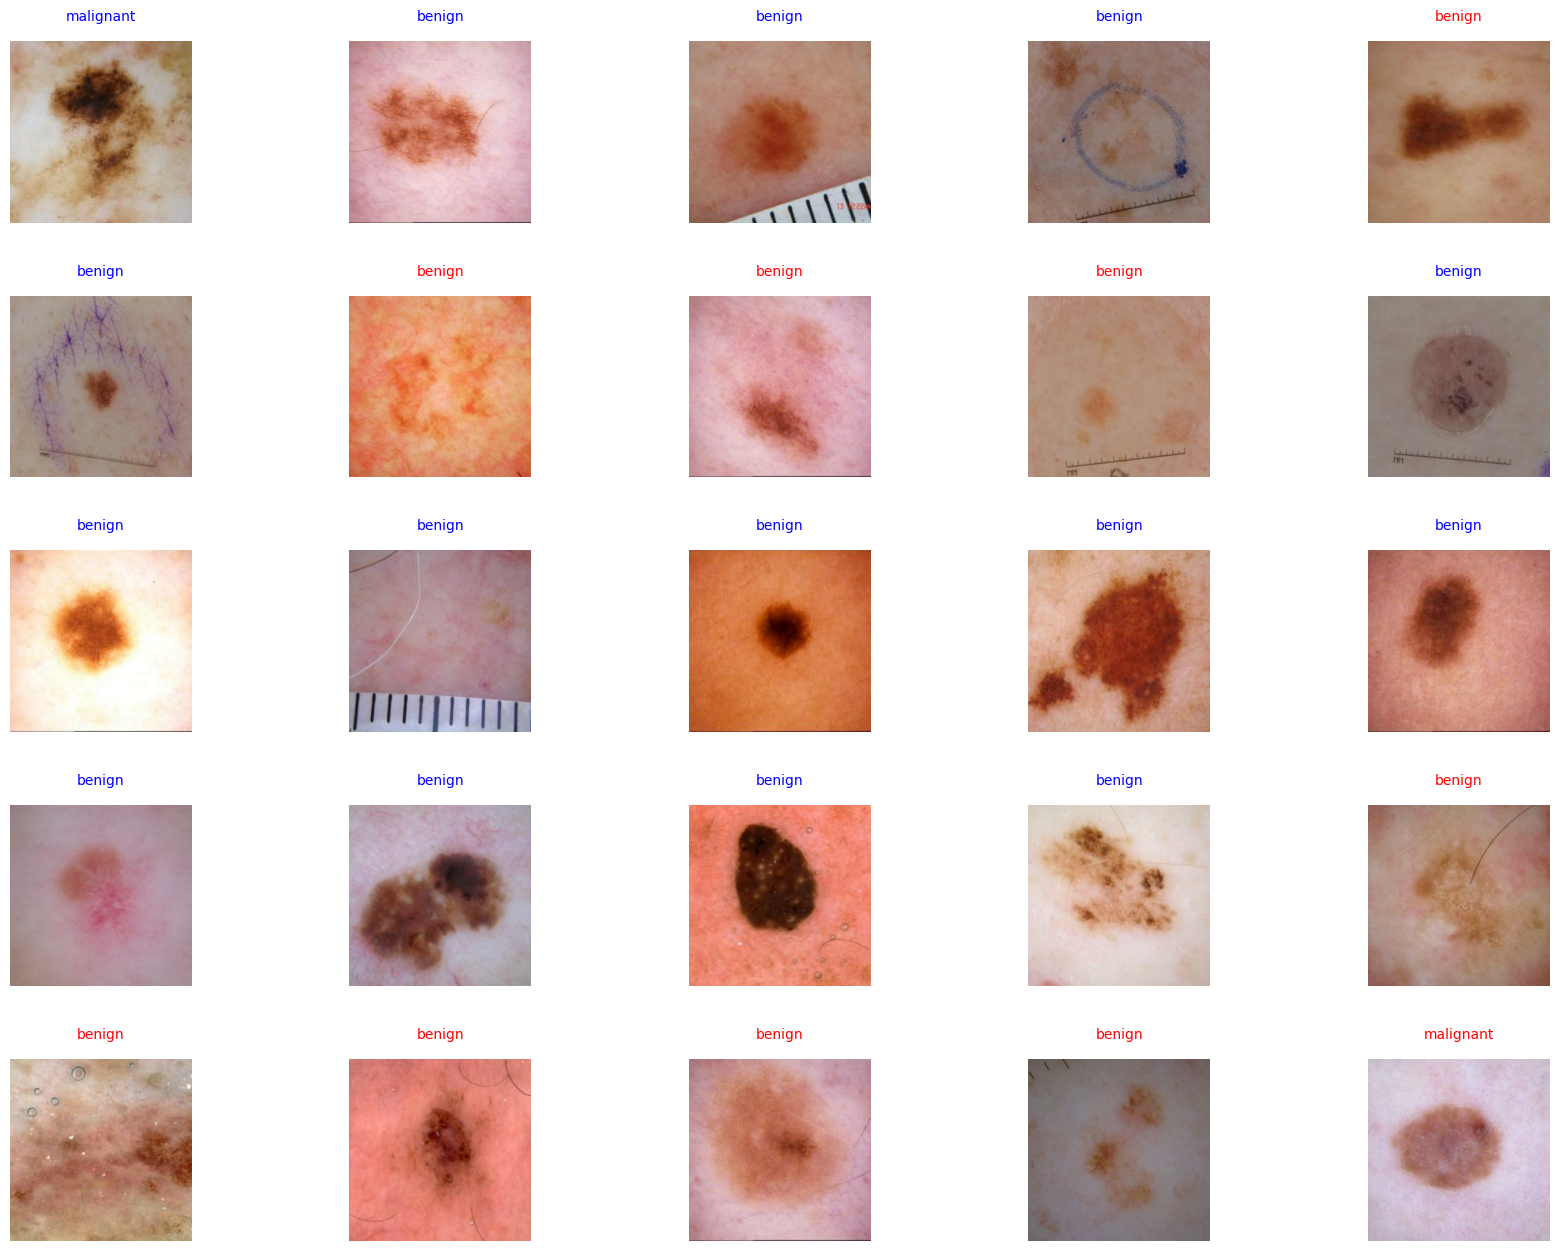

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in test_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)

###**<font color='green'>Training and Validation Accuracy </font> & <font color='red'>Training and Validation Loss </font>**

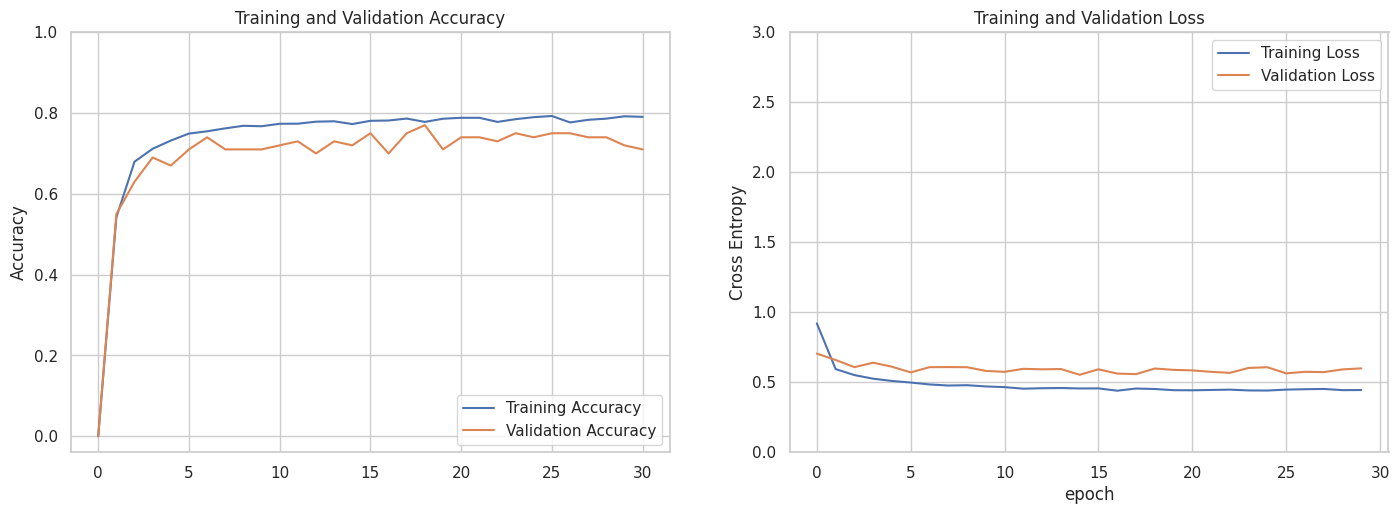

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

###**True and Predicted labels**

In [ ]:
from sklearn.preprocessing import label_binarize

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset and make predictions
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Binarize the true and predicted labels
true_labels_bin = label_binarize(true_labels, classes=np.unique(true_labels))
predicted_labels_bin = label_binarize(predicted_labels, classes=np.unique(predicted_labels))

4/4 [==============================] - 3s 470ms/step


###**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)

              precision    recall  f1-score   support

      benign       0.88      0.73      0.79       796
   malignant       0.36      0.60      0.45       204

    accuracy                           0.70      1000
   macro avg       0.62      0.66      0.62      1000
weighted avg       0.77      0.70      0.72      1000



###**ROC Curve for Multiclass Classification**

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Compute class-specific ROC AUC values
roc_auc_per_class = []
for i in range(len(class_names)):
    roc_auc = roc_auc_score(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc_per_class.append(roc_auc)

# Plot class-specific ROC curves
plt.figure(figsize=(10, 8))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(true_labels_bin[:, i], predicted_labels_bin[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}) for {class_names[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
##change the model name
plt.title('ROC Curves for Multiclass Classification of *model name*')
plt.legend(loc='lower right')
plt.show()

# Print class-specific ROC AUC values
for i in range(len(class_names)):
    print(f'ROC AUC for {class_names[i]}: {roc_auc_per_class[i]:.4f}')

IndexError: index 1 is out of bounds for axis 1 with size 1

### **Confusion Matrix**

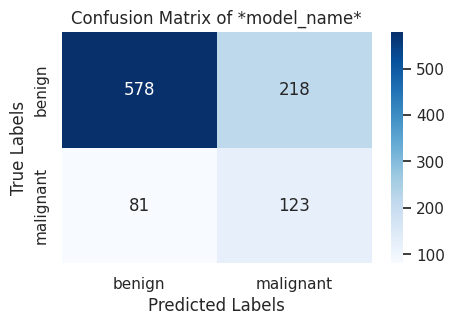

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
## change the model name
plt.title('Confusion Matrix of *model_name*')
plt.show()

###**Cohen's Kappa**

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels, predicted_labels)
print(f'Cohen\'s Kappa: {kappa:.4f}')

Cohen's Kappa: 0.2633


###**Matthews Correlation Coefficient (MCC)**

In [ ]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

# Assuming true_labels and predicted_labels are multiclass labels
mcc_values = [matthews_corrcoef(true_labels == i, predicted_labels == i) for i in np.unique(true_labels)]

average_mcc = np.mean(mcc_values)
print(f'Average Matthews Correlation Coefficient for Multiclass: {average_mcc:.4f}')

Average Matthews Correlation Coefficient for Multiclass: 0.2797


###**Right and Wrong Prediction**

In [ ]:
# Calculate total right and wrong predictions
total_right = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
total_wrong = sum(1 for true, pred in zip(true_labels, predicted_labels) if true != pred)
total_samples = len(true_labels)

# Calculate wrong prediction percentage
wrong_prediction_percentage = (total_wrong / total_samples) * 100

print("Total Right Predictions:", total_right)
print("Total Wrong Predictions:", total_wrong)
print("Wrong Prediction Percentage: {:.2f}%".format(wrong_prediction_percentage))


Total Right Predictions: 701
Total Wrong Predictions: 299
Wrong Prediction Percentage: 29.90%


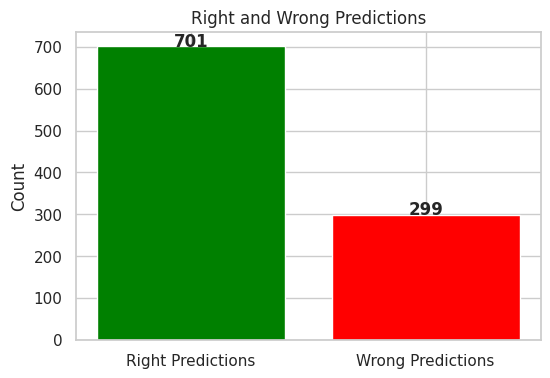

In [ ]:
# Prepare data for plotting
categories = ['Right Predictions', 'Wrong Predictions']
values = [total_right, total_wrong]

# Create a bar plot
plt.figure(figsize=(6, 4))
plt.bar(categories, values, color=['green', 'red'])
plt.ylabel('Count')
plt.title('Right and Wrong Predictions')

# Show counts on top of the bars
for i, v in enumerate(values):
    plt.text(i, v + 0.1, str(v), ha='center', fontweight='bold')

plt.show()

In [ ]:
# Calculate AUC
auc = roc_auc_score(true_label, predicted_labels)

print("AUC: {:.2f}".format(auc))

NameError: name 'true_label' is not defined

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
TN, FP, FN, TP = cm.ravel()

# Right and wrong classifications
right_classifications = TP + TN
wrong_classifications = FP + FN

# Calculate percentages
total = right_classifications + wrong_classifications
right_percentage = (right_classifications / total) * 100
wrong_percentage = (wrong_classifications / total) * 100

# Data for the bar plot
labels = ['Right', 'Wrong']
percentages = [right_percentage, wrong_percentage]


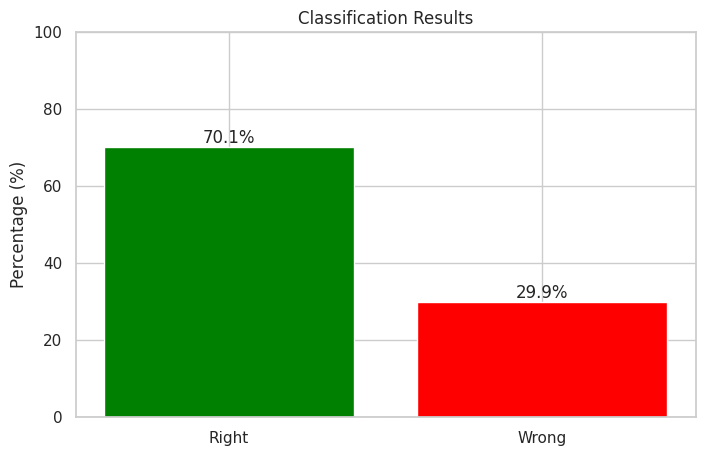

In [ ]:
# Create the bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, percentages, color=['green', 'red'])

# Add percentage labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%',
             ha='center', va='bottom')  # va: vertical alignment

# Add titles and labels
plt.title('Classification Results')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')  # Optional: Add a horizontal line at y=0

# Show the plot
plt.show()

4/4 [==============================] - 2s 485ms/step


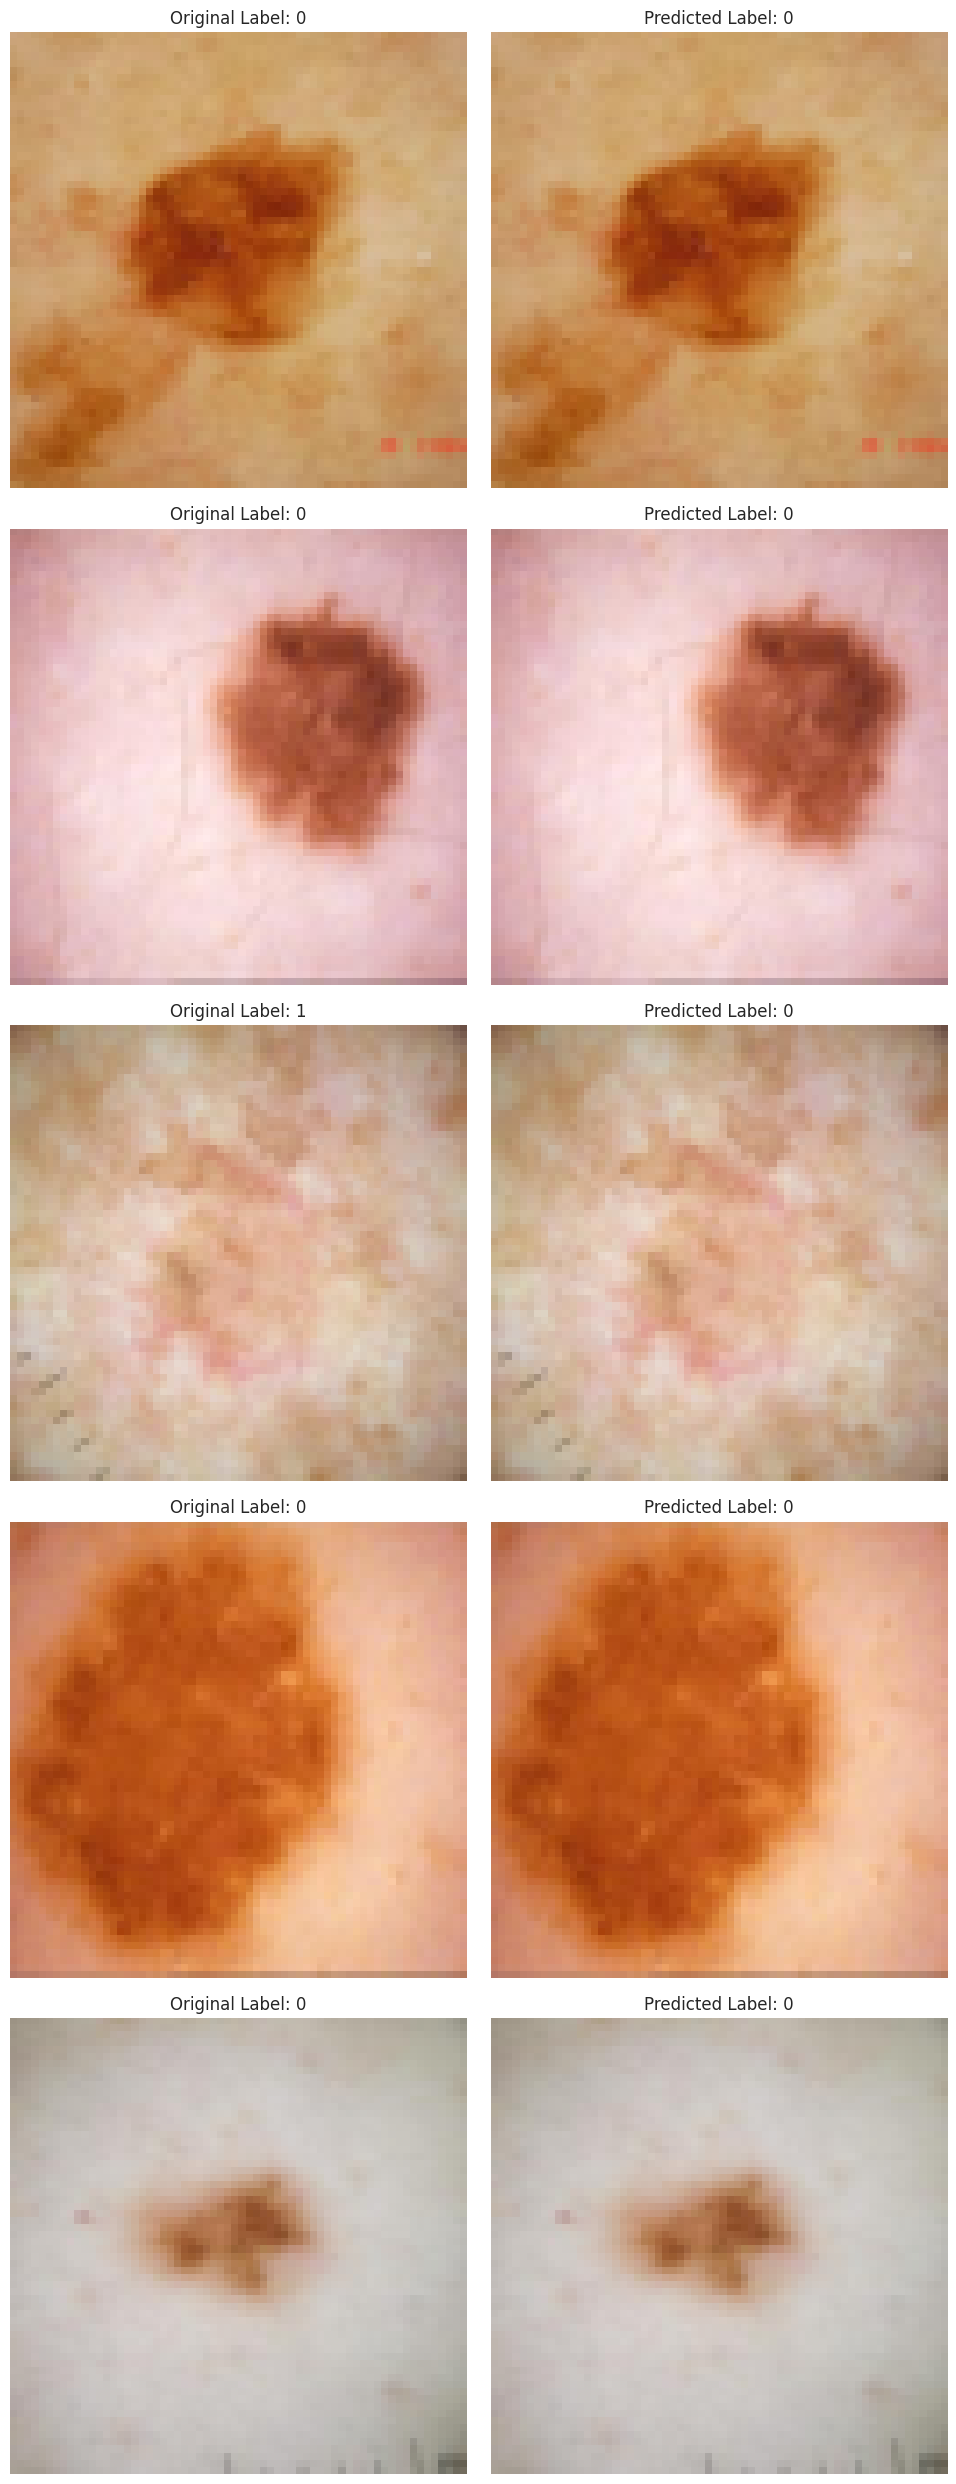

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

# Function to load a specified number of random images from subfolders
def load_random_images_from_subfolders(folder, num_images=5):
    images = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            image_files = os.listdir(subfolder_path)
            # Randomly select images from this subfolder
            selected_files = random.sample(image_files, min(num_images, len(image_files)))
            for image_file in selected_files:
                img_path = os.path.join(subfolder_path, image_file)
                img = Image.open(img_path)
                img = img.resize((64, 64))  # Resize to a consistent size if necessary
                images.append(np.array(img) / 255.0)  # Normalize pixel values
                if len(images) >= num_images:  # Stop if we have enough images
                    break
        if len(images) >= num_images:  # Stop checking subfolders if we have enough images
            break
    return np.array(images)

# Set the path to your test folder
test_folder = '/content/drive/MyDrive/ISIC2018/test'  # Folder containing subfolders of images

# Load exactly 5 random images from subfolders
images = load_random_images_from_subfolders(test_folder, num_images=5)

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset and make predictions
for images_batch, labels in test_dataset:  # Replace test_dataset with your actual dataset variable
    predictions = model.predict(images_batch)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Ensure that we are only working with the number of images we loaded
num_loaded_images = len(images)
if len(true_labels) > num_loaded_images:
    true_labels = true_labels[:num_loaded_images]
if len(predicted_labels) > num_loaded_images:
    predicted_labels = predicted_labels[:num_loaded_images]

# Set up the plot
cols = 2  # Two columns: original and predicted
rows = num_loaded_images  # One row for each loaded image

fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))

# Loop through and display images
for i in range(num_loaded_images):
    original_image = images[i]
    predicted_label = predicted_labels[i]
    true_label = true_labels[i]

    # Plot original image
    axes[i, 0].imshow(original_image)
    axes[i, 0].set_title(f'Original Label: {true_label}')
    axes[i, 0].axis('off')

    # Plot predicted image (optionally the same image)
    axes[i, 1].imshow(original_image)
    axes[i, 1].set_title(f'Predicted Label: {predicted_label}')
    axes[i, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Calculate sensitivity, specificity, and Jaccard index
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

# Print the results
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

Sensitivity: 0.00
Specificity: 1.00


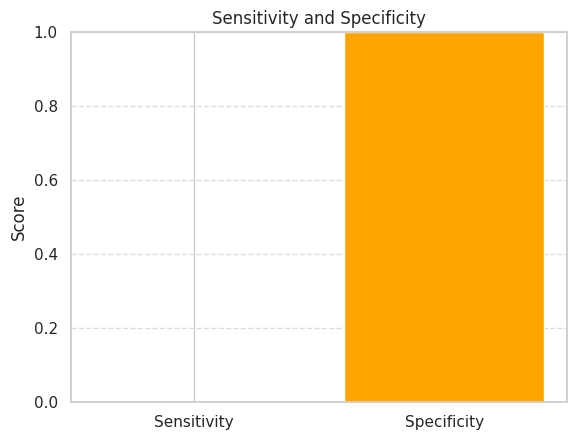

In [ ]:
# Metrics for plotting
metrics = [sensitivity, specificity]
labels = ['Sensitivity', 'Specificity']

# Create bar plot
plt.bar(labels, metrics, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.ylabel('Score')
plt.title('Sensitivity and Specificity')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [ ]:
# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()

# Calculate Jaccard Index
jaccard_index = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

# Calculate Dice Score
dice_score = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0

# Print results
print(f"Jaccard Index: {jaccard_index:.2f}")
print(f"Dice Score: {dice_score:.2f}")

Jaccard Index: 0.00
Dice Score: 0.00


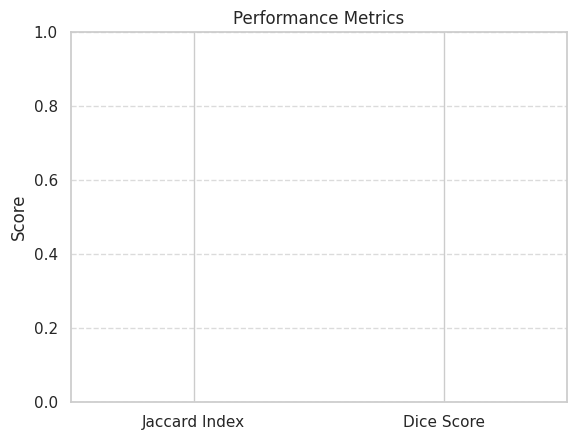

In [ ]:
# Metrics for plotting
metrics = [jaccard_index, dice_score]
labels = ['Jaccard Index', 'Dice Score']

# Create bar plot
plt.bar(labels, metrics, color=['blue', 'orange'])
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.ylabel('Score')
plt.title('Performance Metrics')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()